In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

In [2]:
dataset = pd.read_excel('SCFP2009panel.xlsx')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame

In [5]:
dataset.shape

(19285, 515)

In [6]:
dataset.isna().sum().sum()

0

In [7]:
print('Null Values =',dataset.isnull().values.any())

Null Values = False


In [8]:
Average_SP500_2007=1478
Average_SP500_2009=948

dataset['RiskFree07']= dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07'] 
dataset['RT07'] = dataset['Risky07']/(dataset['Risky07']+dataset['RiskFree07'])

dataset['RiskFree09']= dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09'] 
dataset['RT09'] = dataset['Risky09']/(dataset['Risky09']+dataset['RiskFree09'])*\
                (Average_SP500_2009/Average_SP500_2007)

In [9]:
dataset2 = copy.deepcopy(dataset)  
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RT07,RiskFree09,Risky09,RT09
0,1,11,11668.134198,47,3,12,2,1,0,2,...,0.0,93.125197,270.403054,57,7994.813847,0.0,0.0,16000,17000,0.330422
1,1,12,11823.456494,47,3,12,2,1,0,2,...,0.0,93.125197,249.593620,57,7994.813847,0.0,0.0,19000,18000,0.312036
2,1,13,11913.228354,47,3,12,2,1,0,2,...,0.0,93.125197,209.233358,57,7984.457871,0.0,0.0,13000,12000,0.307876
3,1,14,11929.394266,47,3,12,2,1,0,2,...,0.0,93.125197,209.273158,57,7984.457871,0.0,0.0,25000,13000,0.219429
4,1,15,11917.722907,47,3,12,2,1,0,2,...,0.0,93.125197,232.690767,57,7994.813847,0.0,0.0,17000,12000,0.265410


In [15]:
dataset2['PercentageChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)

In [16]:
print('Null Values =',dataset2.isnull().values.any())

Null Values = True


In [17]:
dataset2=dataset2.dropna(axis=0)

dataset2=dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(1)]

print('Null Values =',dataset2.isnull().values.any())

Null Values = False


<AxesSubplot:xlabel='RT07'>

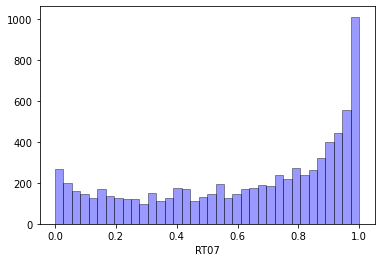

In [18]:
sns.distplot(dataset2['RT07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='RT09'>

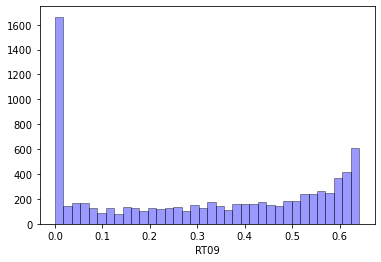

In [19]:
sns.distplot(dataset2['RT09'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [20]:
dataset3 = copy.deepcopy(dataset2)  

In [21]:
dataset3 = dataset3[dataset3['PercentageChange']<=.1]

In [22]:
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09'])/2

In [23]:
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

In [24]:
keep_list2 = ['AGE07','EDCL07','MARRIED07','KIDS07','OCCAT107','INCOME07','RISK07','NETWORTH07','TrueRiskTolerance'
]

drop_list2 = [col for col in dataset3.columns if col not in keep_list2]

dataset3.drop(labels=drop_list2, axis=1, inplace=True)

<AxesSubplot:xlabel='TrueRiskTolerance'>

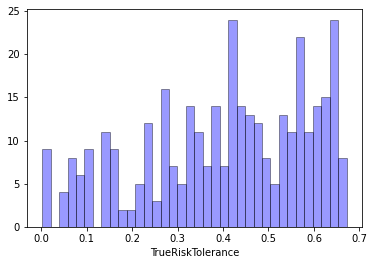

In [25]:
sns.distplot(dataset3['TrueRiskTolerance'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='AGE07'>

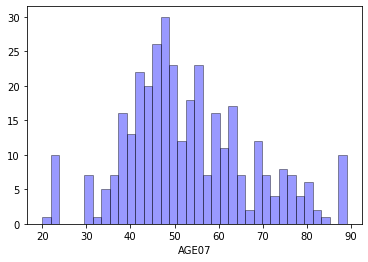

In [26]:
sns.distplot(dataset3['AGE07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='EDCL07'>

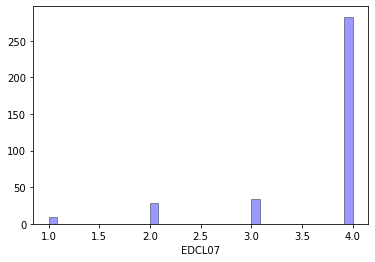

In [27]:
sns.distplot(dataset3['EDCL07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='MARRIED07'>

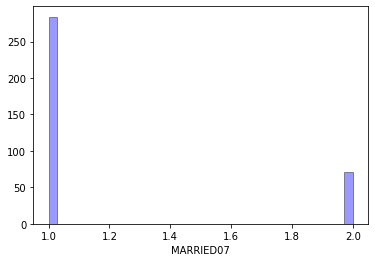

In [28]:
sns.distplot(dataset3['MARRIED07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='KIDS07'>

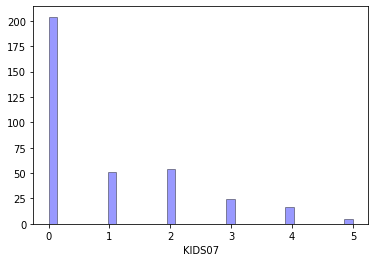

In [29]:
sns.distplot(dataset3['KIDS07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='OCCAT107'>

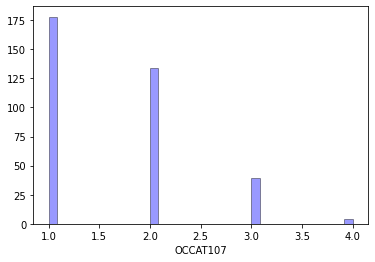

In [30]:
sns.distplot(dataset3['OCCAT107'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='INCOME07'>

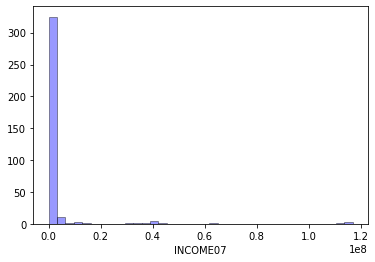

In [31]:
sns.distplot(dataset3['INCOME07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='RISK07'>

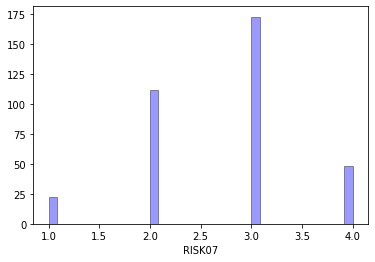

In [32]:
sns.distplot(dataset3['RISK07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='NETWORTH07'>

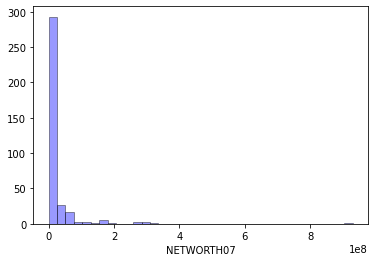

In [33]:
sns.distplot(dataset3['NETWORTH07'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

Let us look at the correlation among the features.

<AxesSubplot:title={'center':'Correlation Matrix'}>

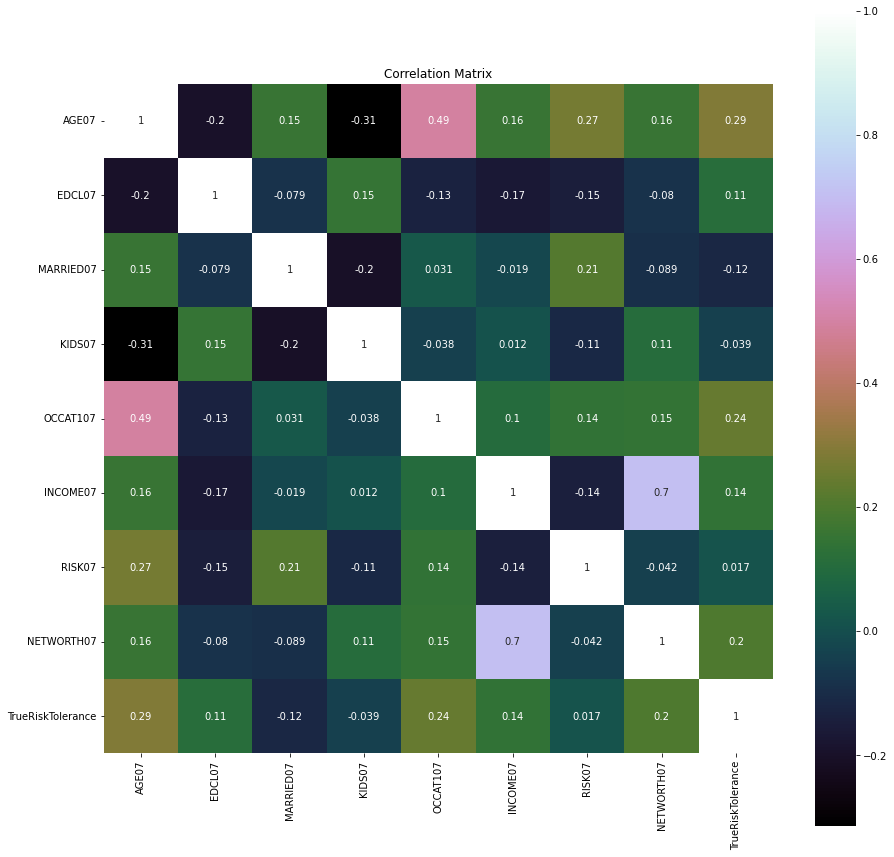

In [34]:
# correlation
correlation = dataset3.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

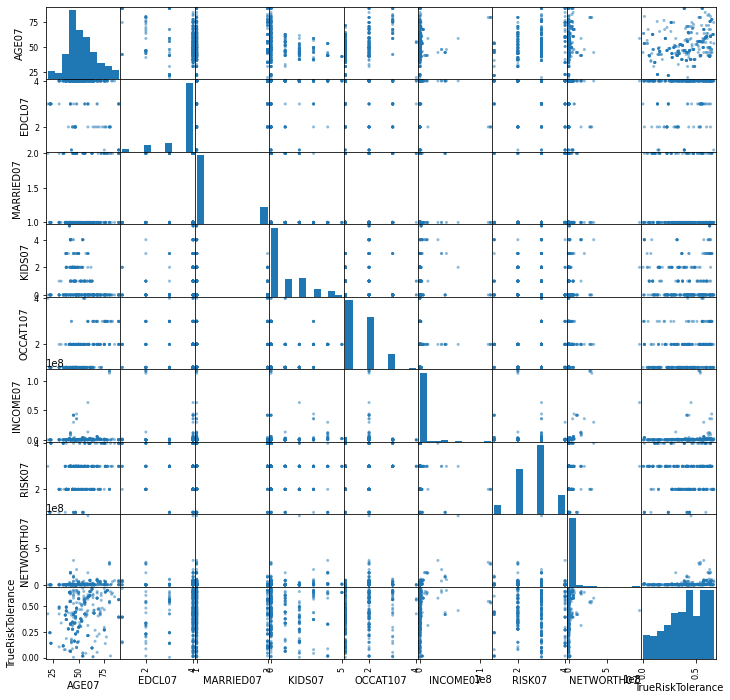

In [35]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
plt.figure(figsize=(15,15))
scatter_matrix(dataset3,figsize=(12,12))
plt.show()

In [36]:
correlations = dataset3.corrwith(dataset3['TrueRiskTolerance'])
correlations = correlations.drop('TrueRiskTolerance')
print(correlations)

AGE07         0.290022
EDCL07        0.113975
MARRIED07    -0.116096
KIDS07       -0.038783
OCCAT107      0.242642
INCOME07      0.139044
RISK07        0.017230
NETWORTH07    0.201585
dtype: float64


In [37]:
x = dataset3.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset3 = pd.DataFrame(x_scaled, columns = ['AGE','EDCL', 'MARRIED','KIDS','OCCAT', 'INCOME', 'RISK','NETWORTH','TrueRiskTolerance'])

<AxesSubplot:xlabel='AGE'>

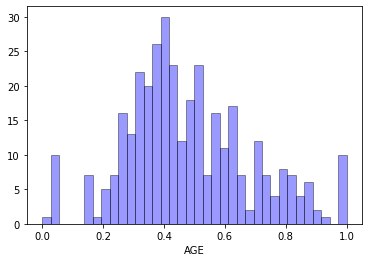

In [38]:
sns.distplot(dataset3['AGE'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='EDCL'>

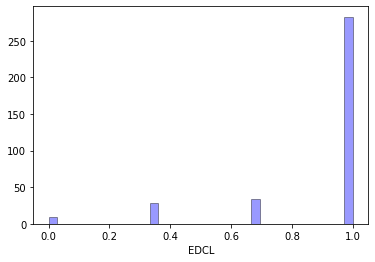

In [39]:
sns.distplot(dataset3['EDCL'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='MARRIED'>

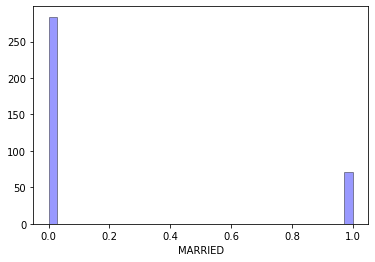

In [40]:
sns.distplot(dataset3['MARRIED'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='OCCAT'>

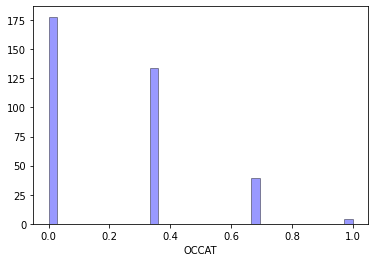

In [41]:
sns.distplot(dataset3['OCCAT'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='INCOME'>

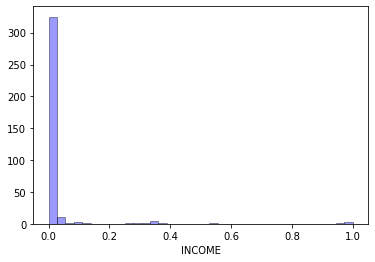

In [42]:
sns.distplot(dataset3['INCOME'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='KIDS'>

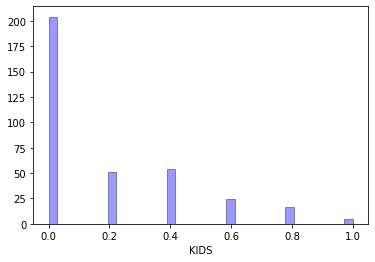

In [43]:
sns.distplot(dataset3['KIDS'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='RISK'>

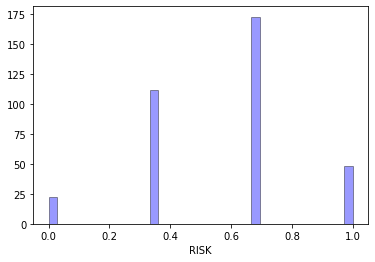

In [44]:
sns.distplot(dataset3['RISK'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='NETWORTH'>

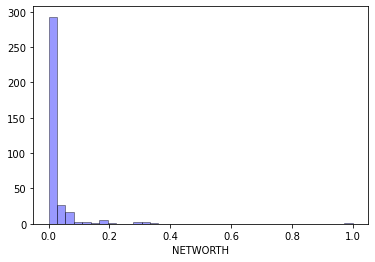

In [45]:
sns.distplot(dataset3['NETWORTH'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

<AxesSubplot:xlabel='TrueRiskTolerance'>

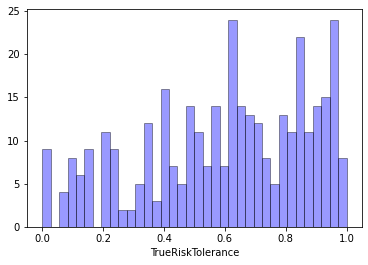

In [46]:
sns.distplot(dataset3['TrueRiskTolerance'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

In [47]:
dataset3.describe()

,AGE,EDCL,MARRIED,KIDS,OCCAT,INCOME,RISK,NETWORTH,TrueRiskTolerance
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,0.478955,0.888263,0.200000,0.182535,0.210329,0.026456,0.565258,0.021685,0.597633
std,0.206823,0.244917,0.400565,0.256947,0.240748,0.118175,0.259861,0.070826,0.271598
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.340580,1.000000,0.000000,0.000000,0.000000,0.000682,0.333333,0.000528,0.407262
50%,0.434783,1.000000,0.000000,0.000000,0.000000,0.001883,0.666667,0.001875,0.627119
75%,0.594203,1.000000,0.000000,0.400000,0.333333,0.006140,0.666667,0.010715,0.835522
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
dataset3.head()

,AGE,EDCL,MARRIED,KIDS,OCCAT,INCOME,RISK,NETWORTH,TrueRiskTolerance
0,0.826087,0.333333,0.0,0.0,0.666667,0.000268,1.000000,0.000298,0.295034
1,0.507246,1.000000,0.0,0.2,0.333333,0.023743,0.333333,0.053439,0.954636
2,0.942029,1.000000,0.0,0.0,0.333333,0.003184,1.000000,0.062824,0.877751
3,0.289855,0.333333,0.0,0.6,0.000000,0.000455,0.666667,0.000356,0.645196
4,0.724638,0.333333,0.0,0.0,0.333333,0.000317,0.666667,0.002233,0.337879


In [49]:
Y= dataset3["TrueRiskTolerance"]
X = dataset3.loc[:, dataset3.columns != 'TrueRiskTolerance']
validation_size = 0.2
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [50]:
num_folds = 10
scoring = 'r2'

In [54]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))
models.append(('MPL', MLPRegressor()))

In [56]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1*cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.102704 (0.179297)
LASSO: 0.032923 (0.039967)
EN: 0.032923 (0.039967)
KNN: -0.328952 (0.202951)
CART: -0.547408 (0.253866)
SVR: -0.273526 (0.153320)
ABR: -0.362209 (0.143752)
GBR: -0.616533 (0.144693)
RFR: -0.698214 (0.113265)
ETR: -0.700787 (0.151108)
MPL: -0.128273 (0.140583)


In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [60]:
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.713362 using {'n_estimators': 300}
0.702973 (0.116198) with: {'n_estimators': 50}
0.712901 (0.095499) with: {'n_estimators': 100}
0.705414 (0.102079) with: {'n_estimators': 150}
0.707318 (0.104681) with: {'n_estimators': 200}
0.708562 (0.108596) with: {'n_estimators': 250}
0.713362 (0.101091) with: {'n_estimators': 300}
0.703861 (0.108336) with: {'n_estimators': 350}
0.702926 (0.103327) with: {'n_estimators': 400}


In [61]:
model = RandomForestRegressor(n_estimators = 300)
model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=300)

In [62]:
from sklearn.metrics import r2_score
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))

0.9640153267398353


In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.017548759160600984
0.7584974916644261


[0.22613736 0.02569685 0.01363206 0.04652436 0.02502328 0.23524706
 0.05065656 0.37708248]


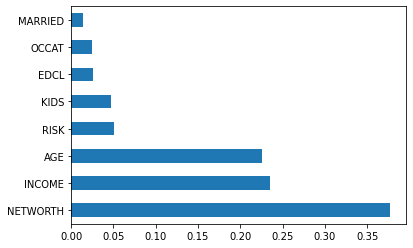

In [64]:
import pandas as pd
import numpy as np
model = RandomForestRegressor(n_estimators= 200,n_jobs=-1)
model.fit(X_train,Y_train)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [66]:
from pickle import dump
from pickle import load
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [67]:
loaded_model = load(open(filename, 'rb'))
predictions = loaded_model.predict(X_validation)
result = mean_squared_error(Y_validation, predictions)
print(r2_score(Y_validation, predictions))
print(result)

0.7682440324548697
0.016840527605743574
